In [2]:
%reload_ext autoreload
%autoreload 2

In [ ]:
try:
    import rlmep
    print("Already installed")
except ImportError:
    %pip install "rlmep[colab] @ git+https://github.com/Mads-PeterVC/rlmep.git" # if you are using Google Colab

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from rlmep.exercise_2 import example_figure

%matplotlib inline

# Materials Science RL Environment.

Now that we've developed an RL algorithm it would be cool to apply it to a material's science problem. 

So this exercise will involve the design and implementation of such an environment. 
Specifically, we will try to frame **minimum energy path** (MEP) finding as an 
RL environment. 

This involves the following decisions

- What is the state space?
- What is the action space? 
- What is the reward structure? 

Our Deep Q-learning algorithm can handle continuous state spaces, but only discrete action spaces.

So for this reason we will start with a discrete state and action space. To keep things simple we will limit 
the scope a little (perhaps more than that) and only consider the movement of a single atom. 

I've made an illustration of the kind of environment we will create below.
Here the red dot indicates the starting position and the initial position and the 
green the final position of an atom. Rather than avoiding drowning, we want our RL algorithm 
to learn to avoid taking a path that crosses high-energy regions.

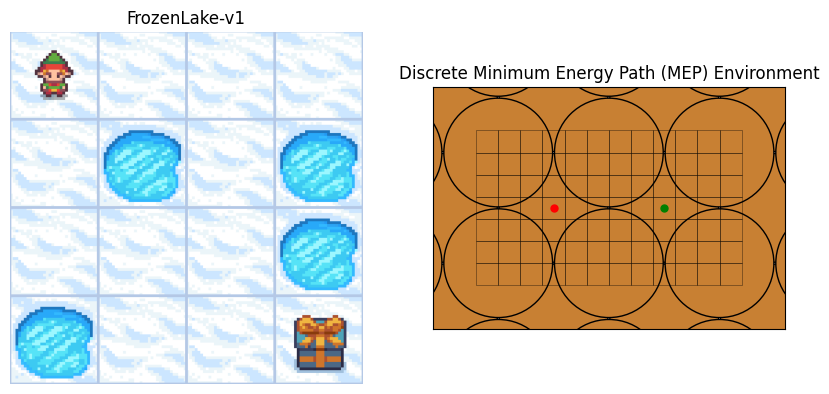

In [5]:
example_figure()

## Implement MEP-environment

### State space

The state-space of our MEP problem will be a 2d-grid. To make handling this grid 
a little easier the `GridSpec`-class provides some methods; 

- `__init__`: Taking the arguments
    - `grid_size` e.g. `(10, 10)`
    - `grid_spacing` e.g. `0.5`
    - `corner` e.g. `(0, 0)`
    - `height` e.g `10.0`.

- `ij_to_xyz`: Takes two arguments `i` and `j` and returns `x`, `y`, `z`.
- `xy_to_ij`: Takes two arguments `x` and `y` and returns `i` and `j`.
- `visualize`: Takes an `Axes`-object and plots the grid.

Convince yourself that these methods work as expected.

In [6]:
from rlmep.exercise_2 import GridSpec

grid_spec = GridSpec(grid_size=(10, 10), grid_spacing=0.5, corner=(0, 0))

grid_spec.ij_to_xyz(1, 1)


(0.5, 0.5, 0.0)

In our environment we will call the position of the moving atom on the grid our `state` which are the 
two indices `(i, j)`.

Our environment also needs to be able to determine when it has reached a terminal or truncated state. 

We will consider the case where the is only one terminal state once the atom has reached a particular 
position on the grid corresponding to a particular set of `state` integers `[i, j]`

In [7]:
def check_terminal(state: list[int, int], terminal_state: list[int, int]) -> bool:
    """
    Check if the state is terminal.
    """
    # Your code here
    terminal = ...

    return terminal

To avoid the agent going on infinitely looping walks we will truncate an episode if a 
maximum amount of steps have been taken. 

In [8]:
def check_truncated(step: int, max_steps: int) -> bool:
    """
    Check if the episode should be truncated.
    """
    # Your code here
    truncated = ...
    return truncated

### Action space

The action space is again a discrete space with four possible values. 

We are mapping (0, 1, 2, 3) to each direction (right, left, up, down) - to conform with the plotting methods 
we want; 

- $ 0 \rightarrow \mathrm{right}$
- $ 1 \rightarrow \mathrm{left}$
- $ 2 \rightarrow \mathrm{up}$
- $ 3 \rightarrow \mathrm{down}$

Complete the function below such when provided an integer it provides the two integers corresponding to a direction on the grid - e.g. 

$ 0 \rightarrow (1, 0)$

In [9]:
def action_to_direction(action: int) -> list[int, int]:
    # Your code here
    direction = ...
    return direction

When trying to move the atom on the grid we also want to make sure it doesn't move out of bounds. 

So we have to make sure that a move cannot take result in grid coordinates below zero - or grid coordinates above the grid size.

In [10]:
def update_state(
    state: list[int, int], action: int, grid_size: tuple[int, int]
) -> list[int, int]:
    direction = action_to_direction(action)

    # Your code here
    new_state = ...
    return new_state

In addition to our integers to represent the state we would also like to manipulate an `ase.Atoms`-object 
based on the state

In [11]:
from ase import Atoms


def update_atoms(
    atoms: Atoms, state: list[int, int], grid_spec: GridSpec, move_index: int
) -> Atoms:
    """
    Update the `ase.Atoms` object based on the state and move index.

    Use the `grid_spec`-object to convert the state to coordinates.
    """
    # Your code here
    atoms = ...

    return atoms

### Reward

The reward function determines what 'solving' the environment looks like - we need to 
encode our intent into the reward function. 

One choice is to say we record the energy difference at each state visited and 
once the final state is reached we base the reward on this trajectory. 

If we define 

$$
\Delta E_i = E_i - E_{init}
$$

And we introduce two parameters $\Delta_{max}$ and $A$ we can write a reward function

$$
r = A \left(1 - \frac{\min \ [\max_i \ ( \Delta E_i), \Delta_{max}]}{\Delta_{max}}\right)
$$

In [12]:
def reward_function(delta_energies: list[float], A: float, delta_max: float) -> float:
    # Your code here
    reward = None
    return reward

### Putting it together

I've created a class that takes your function definitions from above and puts it together 
with a few tedious tidbits done for you. 

In [13]:
from rlmep.exercise_2.discrete_mep_scaffold import ScaffoldDiscreteMEP, _get_cheat_functions
from rlmep.exercise_2.diffusion_env import get_diffusion_state_grid
from ase.calculators.emt import EMT

functions = {
    "check_terminal": check_terminal,
    "check_truncated": check_truncated,
    "update_state": update_state,
    "update_atoms": update_atoms,
    "reward_function": reward_function,
}

functions = _get_cheat_functions()

intial_config, final_config, grid_spec = get_diffusion_state_grid(
    grid_size=(12, 7),
    grid_spacing=0.5,
    grid_shift=(-3, -3),
)

env = ScaffoldDiscreteMEP(
    initial_config=intial_config,
    final_config=final_config,
    gridspec=grid_spec,
    functions=functions,
    moving_atom=-1,
    max_steps=100,
    barrier_max=2.5,
    reward_scale=10.0,
    calculator=EMT()
)

### Sanity check

Text(0.5, 1.0, 'Reward: 2.49')

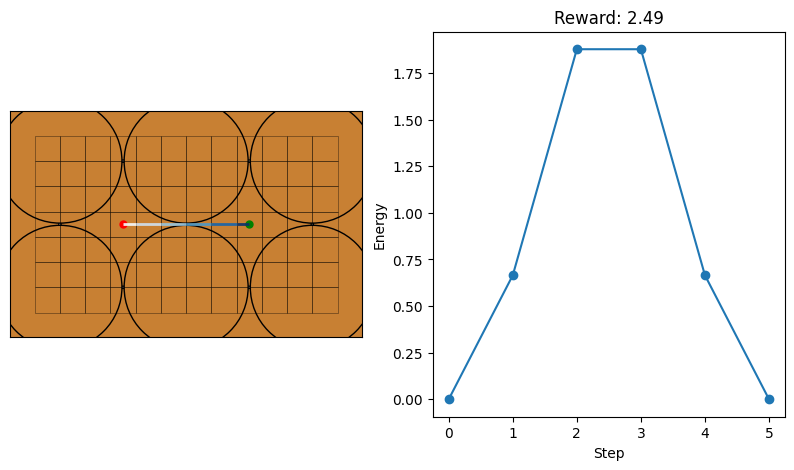

In [14]:
action_trajectory = [1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 2, 2, 2, 2, 2, 2, 2] # Use to make a specific action trajectory


state, info = env.reset()
states = [state]


for step in range(50):
    # action = env.action_space.sample()  # Random action
    action = 0 # Always move right
    # action = action_trajectory.pop(0) if action_trajectory else env.action_space.sample()  # Use predefined actions or random

    state, reward, terminal, truncated, info = env.step(action)

    states.append(state)

    if terminal or truncated:
        break


fig, ax = plt.subplots(1, 2, figsize=(10, 5))

env.reset()
env.visualize(ax=ax[0], dx=0.5, dy=0.5, plot_moving=False, state_history=states)


ax[1].plot(info['history'], "-o", label="Energy")
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Energy")
ax[1].set_title(f"Reward: {reward:0.2f}", )


## Test

In [15]:
# Make the cartpole environment.
from rlmep.exercise_1.dqn_learner import DQN_learner
from rlmep.exercise_1.qnet import Qnet
from rlmep.exercise_1.experience_replay import ExperienceReplay
import torch

env.reset()

# Set the action and observation dimensions:
obs_dim = 2
n_actions = 4

# Set the network settings:
main_network = Qnet(input_dim=obs_dim, output_dim=n_actions)
target_network = Qnet(input_dim=obs_dim, output_dim=n_actions)
replay = ExperienceReplay(observation_dim=obs_dim, size=2000, batch_size=32)

# Make a learner:
learner = DQN_learner(env, main_network, target_network, replay)
num_episodes = 250
returns, lengths = learner.learn(
    num_episodes=num_episodes,
    gamma=0.90,
    train_interval=1,
    copy_interval=25,
    epsilon=lambda i: 1 - (i / num_episodes) * 0.9,
)

test_returns, test_lengths = learner.test(N=10)

Output()

Output()

In [16]:
Q_table_nn = np.zeros((env.gridspec.grid_size[0], env.gridspec.grid_size[1], 4))
for i in range(env.gridspec.grid_size[0]):
    for j in range(env.gridspec.grid_size[1]):
        Q_table_nn[i, j, :] = (
            main_network(torch.tensor([i, j], dtype=torch.float))
            .detach()
            .numpy()
            .flatten()
        )

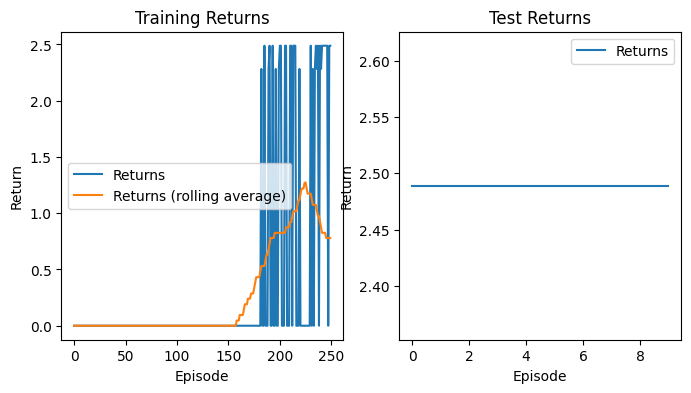

In [17]:
def rolling_average(x, N):
    return np.convolve(np.array(x).flatten(), np.ones((N,)) / N, mode="same")


fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(returns, label="Returns")
ax[0].plot(rolling_average(returns, 50), label="Returns (rolling average)")
ax[0].set_title("Training Returns")
ax[0].set_xlabel("Episode")
ax[0].set_ylabel("Return")
ax[0].legend()

ax[1].plot(test_returns, label="Returns")
ax[1].set_title("Test Returns")
ax[1].set_xlabel("Episode")
ax[1].set_ylabel("Return")
ax[1].legend()

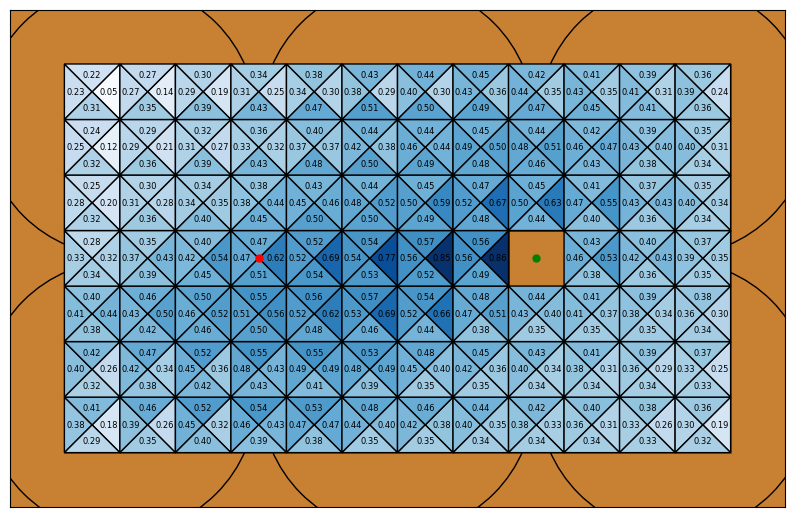

In [18]:
from rlmep.exercise_2 import plot_qvalues

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

env.reset()
env.visualize(ax=ax, dx=0.5, dy=0.5, plot_moving=False)
ax = plot_qvalues(ax, Q_table_nn, env)